In [2]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import torch
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from data_utility import *
from data_utils import *
from loss import *
from train import *
from deeplab_model.deeplab import *
from sync_batchnorm import convert_model
import datetime

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
USE_GPU = True
NUM_WORKERS = 12
BATCH_SIZE = 2

dtype = torch.float32 
# define dtype, float is space efficient than double

if USE_GPU and torch.cuda.is_available():
    
    device = torch.device('cuda')
    
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    # magic flag that accelerate
    
    print('using GPU for training')
else:
    device = torch.device('cpu')
    print('using CPU for training')

using GPU for training


In [4]:
train_dataset = get_full_resolution_dataset(data_type = 'nii_train', 
                transform=transforms.Compose([
                random_affine(90, 15),
                random_filp(0.5)]))
# do data augumentation on train dataset

validation_dataset = get_full_resolution_dataset(data_type = 'nii_test', 
                transform=None)
# no data augumentation on validation dataset

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                    num_workers=NUM_WORKERS)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True,
                    num_workers=NUM_WORKERS) # drop_last
# loaders come with auto batch division and multi-thread acceleration

In [5]:
"""
deeplab = DeepLab(output_stride=16)
deeplab = nn.DataParallel(deeplab)
deeplab = convert_model(deeplab)
deeplab = deeplab.to(device=device, dtype=dtype)
#shape_test(icnet1, True)
# create the model, by default model type is float, use model.double(), model.float() to convert
# move the model to desirable device

optimizer = optim.Adam(deeplab.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
epoch = 0

# create an optimizer object
# note that only the model_2 params and model_4 params will be optimized by optimizer
"""

"\ndeeplab = DeepLab(output_stride=16)\ndeeplab = nn.DataParallel(deeplab)\ndeeplab = convert_model(deeplab)\ndeeplab = deeplab.to(device=device, dtype=dtype)\n#shape_test(icnet1, True)\n# create the model, by default model type is float, use model.double(), model.float() to convert\n# move the model to desirable device\n\noptimizer = optim.Adam(deeplab.parameters(), lr=1e-2)\nscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)\nepoch = 0\n\n# create an optimizer object\n# note that only the model_2 params and model_4 params will be optimized by optimizer\n"

In [10]:
min_val, epoch = get_min_validation('train_bv_refine_resize2.txt')
print(min_val, epoch)
checkpoint_file = find_file_with_epoch(epoch, '../refine_bv_resize_save')
print(checkpoint_file)

0.0578 476
../refine_bv_resize_save/2019-08-25 17:31:04.294911 epoch: 476.pth


In [12]:
from refinenet import refine_net

deeplab = DeepLab(output_stride=16)
deeplab = nn.DataParallel(deeplab)
deeplab = convert_model(deeplab)

optimizer = optim.Adam(deeplab.parameters(), lr=1e-2)

checkpoint = torch.load('../deeplab_dilated_save/2019-08-10 09:28:43.844872 epoch: 1160.pth') # best

deeplab.load_state_dict(checkpoint['state_dict_1'])
deeplab = deeplab.to(device, dtype)

checkpoint_refine = torch.load(checkpoint_file)

refine_model = refine_net(num_classes=1)
refine_model.load_state_dict(checkpoint_refine['state_dict_1'])

refine_model = refine_model.to(device, dtype)

print(checkpoint['epoch'])
print(checkpoint_refine['epoch'])

1160
476



0it [00:00, ?it/s]
1it [00:21, 21.38s/it]

0.04440358281135559



2it [00:24, 15.84s/it]

0.048869699239730835



3it [00:28, 12.32s/it]

0.05231219530105591



4it [00:30,  9.34s/it]

0.03443801403045654



5it [00:33,  7.21s/it]

0.029719918966293335



6it [00:35,  5.68s/it]

0.058284759521484375



7it [00:37,  4.62s/it]

0.05040484666824341



8it [00:39,  3.83s/it]

0.0630311369895935



9it [00:41,  3.31s/it]

0.037235647439956665



10it [00:43,  2.90s/it]

0.07364359498023987


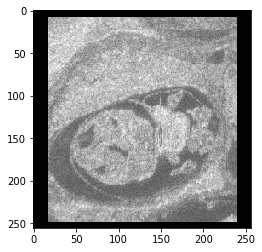

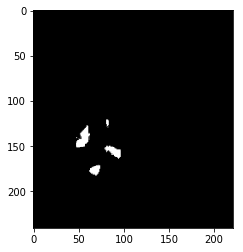

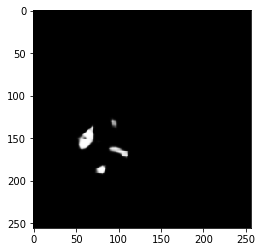

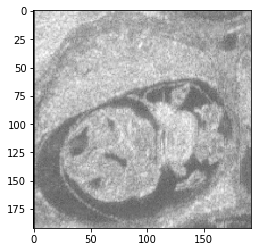

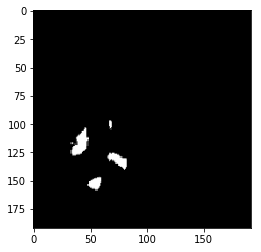

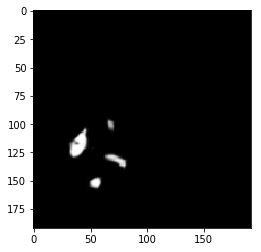

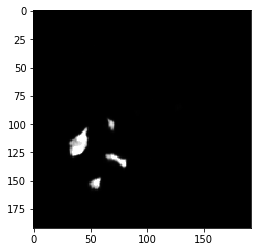


11it [00:46,  2.97s/it]

0.09152626991271973



12it [00:48,  2.69s/it]

0.062302976846694946



13it [00:50,  2.51s/it]

0.07020610570907593


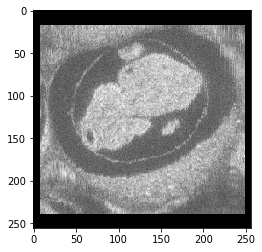

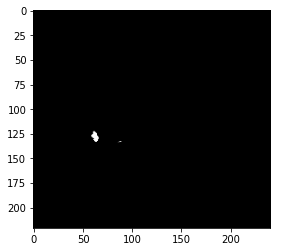

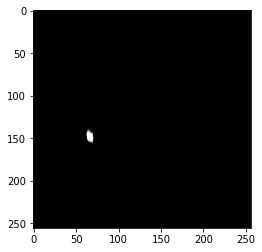

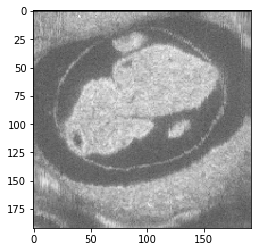

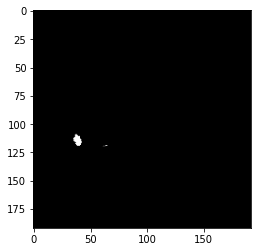

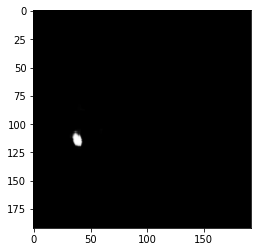

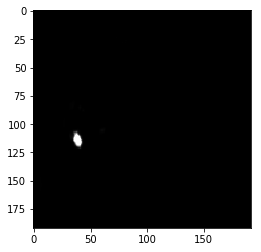


14it [00:53,  2.62s/it]

0.15342608094215393



15it [00:55,  2.47s/it]

0.04046902060508728



16it [00:57,  2.32s/it]

0.03390452265739441



17it [00:59,  2.25s/it]

0.036741435527801514



18it [01:01,  2.15s/it]

0.041811972856521606



19it [01:03,  2.14s/it]

0.07364758849143982



20it [01:05,  2.05s/it]

0.04278534650802612



21it [01:07,  2.08s/it]

0.060805946588516235



22it [01:09,  2.03s/it]

0.058618903160095215



23it [01:11,  2.05s/it]

0.07182413339614868
bv loss = 0.0578



In [14]:
deeplab.eval()
refine_model.eval()

with torch.no_grad():

    val_loss = 0
    
    for v, vbatch in tqdm(enumerate(validation_loader)):
        # move data to device, convert dtype to desirable dtype
        val_losses = []
        for minibatch in range(BATCH_SIZE):
            image_1 = vbatch['image1_data'][minibatch].to(device=device, dtype=dtype)
            image_1 = image_1.view(1,1,256,256,256)

            label_1 = vbatch['image1_label'][minibatch].to(device=device, dtype=dtype)
            label_1 = label_1.view(1,3,256,256,256)

            bv_label = label_1[:, 2, :, :, :]
            bv_label = bv_label.view(1,1,256,256,256)

            original_res = [a[minibatch].item() for a in vbatch['original_resolution']]

            image_1_resize = F.interpolate(image_1, size=original_res, mode='trilinear', align_corners=True)
            image_1_resize = image_1_resize.view(1,1,original_res[0], original_res[1], original_res[2])

            bv_label_resize = F.interpolate(bv_label, size=original_res, mode='trilinear', align_corners=True)

            # Get coarse output from deeplab model from 256 resolution input
            out_coarse = deeplab(image_1)
            out_coarse = out_coarse.view(1,3,256,256,256)

            bv_coarse = out_coarse[:, 2, :, :, :]
            bv_coarse = bv_coarse.view(1,1,256,256,256)

            bv_coarse_resize = F.interpolate(bv_coarse, size=original_res, mode='trilinear', align_corners=True)
            
            box_size = 192
            half_size = int(box_size / 2)
            
            image_size_x = int(image_1_resize.shape[-3])
            image_size_y = int(image_1_resize.shape[-2])
            image_size_z = int(image_1_resize.shape[-1])
            
            x,y,z = loadbvcenter(binarize_output(bv_coarse_resize).view([1] + original_res))
            x, y, z = np.clip([x, y, z], a_min=box_size-half_size, a_max=box_size+half_size)
            x1 = max(x-half_size, 0)
            x2 = min(x+half_size, image_size_x)
            y1 = max(y-half_size, 0)
            y2 = min(y+half_size, image_size_y)
            z1 = max(z-half_size, 0)
            z2 = min(z+half_size, image_size_z)
            
            
            bbox_bv = bv_coarse_resize.view(original_res)[x1:x2, y1:y2, z1:z2]
            bbox_bv = reshape_image(bbox_bv.squeeze(), box_size, box_size, box_size).to(device, dtype)
            bbox_bv = bbox_bv.view(1,1,box_size,box_size,box_size)
            
            bbox_bv_label = bv_label_resize.view(original_res)[x1:x2, y1:y2, z1:z2]
            bbox_bv_label = reshape_image(bbox_bv_label.squeeze(), box_size, box_size, box_size).to(device, dtype)
            bbox_bv_label = bbox_bv_label.view(1,1,box_size,box_size,box_size)

            #bbox_image = get_bounding_box_image(image_1, (256,256,256)).to(device, dtype)
            bbox_image = image_1_resize[:, :, x1:x2, y1:y2, z1:z2]
            bbox_image = reshape_image(bbox_image.squeeze(), box_size, box_size, box_size).to(device, dtype)
            bbox_image = bbox_image.view(1, 1, box_size, box_size, box_size)
            
            #bbox_iamge, bbox_bv_label, bbox_bv = get_bboxes(image_1_resize, bv_label_resize, bv_coarse_resize, 1, 200)
            
            bbox_concat = torch.cat([bbox_bv, bbox_image], dim=1)
            bbox_concat_2 = F.interpolate(bbox_concat, scale_factor=1/2, mode='trilinear', align_corners=True)
            bbox_concat_4 = F.interpolate(bbox_concat, scale_factor=1/4, mode='trilinear', align_corners=True)

            refine_out = refine_model(bbox_concat, bbox_concat_2, bbox_concat_4)

            loss = dice_loss(refine_out, bbox_bv_label)
            val_losses.append(loss)
            
            if loss.item() > .1:
                show_image_slice(image_1)
                show_image_slice(bv_label_resize)
                show_image_slice(bv_coarse)
                show_image_slice(bbox_image)
                show_image_slice(bbox_bv_label)
                show_image_slice(bbox_bv)
                show_image_slice(refine_out)
        
        loss = sum(val_losses) / BATCH_SIZE
        print(loss.item())
        val_loss += loss.item()
        val_losses = []
        '''
        if loss.item() > .05:
            show_image_slice(image_1)
            show_image_slice(label_1)
            show_image_slice(output)
        '''

    outstr = 'bv loss = {0:.4f}'\
        .format(val_loss/(v+1)) + '\n'
    
    print(outstr)